<a href="https://colab.research.google.com/github/PawanKrGunjan/Computer-Vision/blob/main/Autoencoder/Convolutional_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import keras
import tensorflow as tf
from keras import backend as k
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
k.clear_session()

In [2]:
# import minist dataset
(x_train, y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()
image_shape = (28,28,1)
latent_dim=2
# change datatype and reshape data
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + image_shape)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + image_shape)

In [3]:
# function to fetch 10 images of label 0 to 9
def get_images_1_to_10(x, y):
    selected_x, selected_y = [], []
    for i in range(10):
        number_index = np.where(y == i)[0]
        random_index = np.random.choice(len(number_index), 1, replace=False)
        select_index = number_index[random_index]
        selected_x.append(x[select_index[0]])
        selected_y.append(y[select_index][0])
    return np.array(selected_x, dtype="float32").reshape((len(selected_x),)+image_shape), np.array(selected_y, dtype="float32")
# select random 10 image of labeled 0 to 9
selected_x,selected_y =  get_images_1_to_10(x_train,y_train)

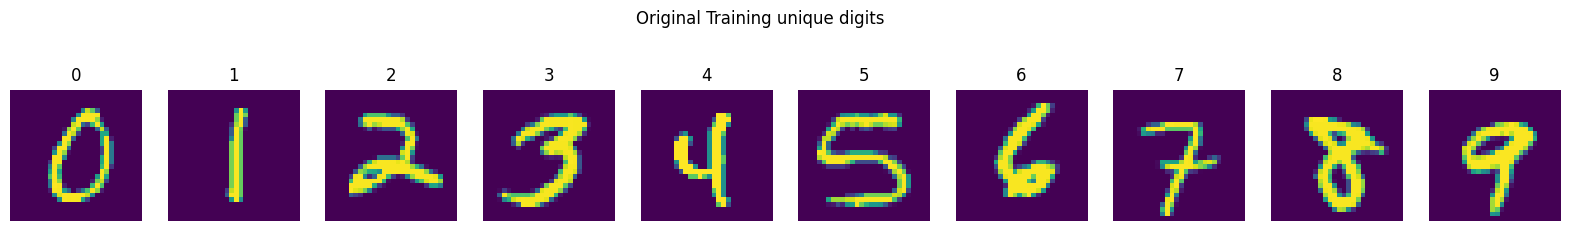

In [4]:
def plot_image(selected_x,selected_y,title=None,save=None):
    ncols = selected_x.shape[0]
    fig,ax  = plt.subplots(nrows=1, ncols=ncols,figsize=(20,3))
    for x,y,ax_i in zip(selected_x,selected_y,ax):
        ax_i.imshow(x.reshape((28,28)))
        ax_i.axis("off")
        ax_i.set_title(int(y))
    if title:
        fig.suptitle(title)
    plt.show()

plot_image(selected_x,selected_y, title='Original Training unique digits',)

# Encoder

In [5]:
# Input
encoder_input = tf.keras.Input(shape=image_shape)
# convolutional layer 1
conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu",)(encoder_input)

# convolutional layer 2
conv_2 = tf.keras.layers.Conv2D(filters=64,
                             kernel_size=3,
                             padding="same",
                             activation="relu",
                            )(conv_1)

# convolutional layer 3
conv_3 = tf.keras.layers.Conv2D(filters=64,
                             kernel_size=3,
                             padding="same",
                             activation="relu",
                            )(conv_2)
# Flatten the data
flatten = tf.keras.layers.Flatten()(conv_3)

# Dense layer 1
encoder_output = tf.keras.layers.Dense(128,activation="relu")(flatten)
z_mu = tf.keras.layers.Dense(latent_dim)(encoder_output)

# Dense layer 2
z_log_sigma = tf.keras.layers.Dense(latent_dim)(encoder_output)

In [6]:
# sampling function for latent layer
def sampling(args):
    z_mu, z_log_sigma = args

    # epsilon in simple normal distribution
    epsilon = k.random_normal(shape=(k.shape(z_mu)[0], latent_dim),mean=0., stddev=1.)
    return z_mu + k.exp(z_log_sigma) * epsilon

z = tf.keras.layers.Lambda(sampling,output_shape=(latent_dim,))([z_mu, z_log_sigma])

# Decoder

In [7]:
# decoder layer
dense_2 = tf.keras.layers.Dense(128,activation="relu")
dense_3 = tf.keras.layers.Dense(np.prod(k.int_shape(conv_3)[1:]),
                             activation="relu"
                            )

# Reshape layer
reshape = tf.keras.layers.Reshape(k.int_shape(conv_3)[1:])

# Deconvolutional layer 1
conv_4 = tf.keras.layers.Conv2DTranspose(filters=64,
                                      kernel_size=3,
                                      padding="same",
                                      activation="relu"
                                     )
# Deconvolutional layer 2
conv_5 = tf.keras.layers.Conv2DTranspose(filters=64,
                                      kernel_size=3,
                                      padding="same",
                                      activation="relu"
                                     )

# Deconvolutional layer 3
conv_6 = tf.keras.layers.Conv2DTranspose(filters=32,
                                      kernel_size=3,
                                      padding="same",
                                      activation="relu"
                                     )

# convolutional layer 4
decoder_output = tf.keras.layers.Conv2D(filters=1,
                                     kernel_size=3,
                                     padding="same",
                                     activation="sigmoid"
                                    )

_dense_2 = dense_2(z)
_dense_3 = dense_3(_dense_2)
_reshape = reshape(_dense_3)
_conv_4 = conv_4(_reshape)
_conv_5 = conv_5(_conv_4)
_conv_6 = conv_6(_conv_5)
_decoder_output = decoder_output(_conv_6)

In [8]:
def vae_loss(x, z_decoded):
    x = k.flatten(x)
    z_decoded = k.flatten(z_decoded)

    # Reconstruction loss
    Reconstruction_loss = 786*keras.metrics.binary_crossentropy(x, z_decoded)

    # KL divergence
    kl_loss = -0.5 * k.mean(1 + z_log_sigma - k.square(z_mu) - k.exp(z_log_sigma), axis=-1)
    return Reconstruction_loss + kl_loss

In [9]:
cvae = keras.Model(encoder_input, _decoder_output)
cvae.compile(optimizer='rmsprop',loss=vae_loss)
cvae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 28, 28, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 28, 28, 64)           36928     ['conv2d_1[0][0]']            
                                                                                              

In [10]:
cvae.fit(x=x_train,y=x_train,
         shuffle=True,
         epochs=10,
         batch_size=64)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 35s 581us/sample - loss: 180.3525
Epoch 2/10
60000/60000 [==============================] - 22s 364us/sample - loss: 149.9667
Epoch 3/10
60000/60000 [==============================] - 22s 369us/sample - loss: 145.2487
Epoch 4/10
60000/60000 [==============================] - 22s 366us/sample - loss: 142.6823
Epoch 5/10
60000/60000 [==============================] - 22s 372us/sample - loss: 141.0701
Epoch 6/10
60000/60000 [==============================] - 22s 362us/sample - loss: 139.8633
Epoch 7/10
60000/60000 [==============================] - 22s 367us/sample - loss: 138.9610
Epoch 8/10
60000/60000 [==============================] - 22s 367us/sample - loss: 138.2938
Epoch 9/10
60000/60000 [==============================] - 22s 362us/sample - loss: 137.6797
Epoch 10/10
60000/60000 [==============================] - 22s 366us/sample - loss: 137.1886


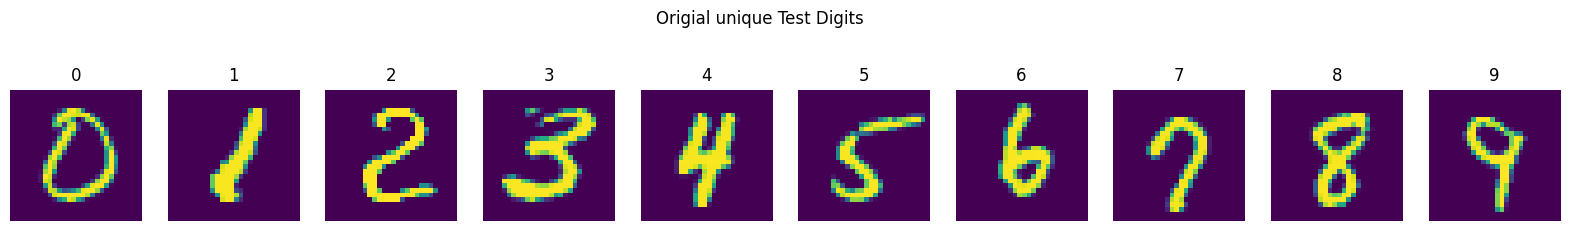

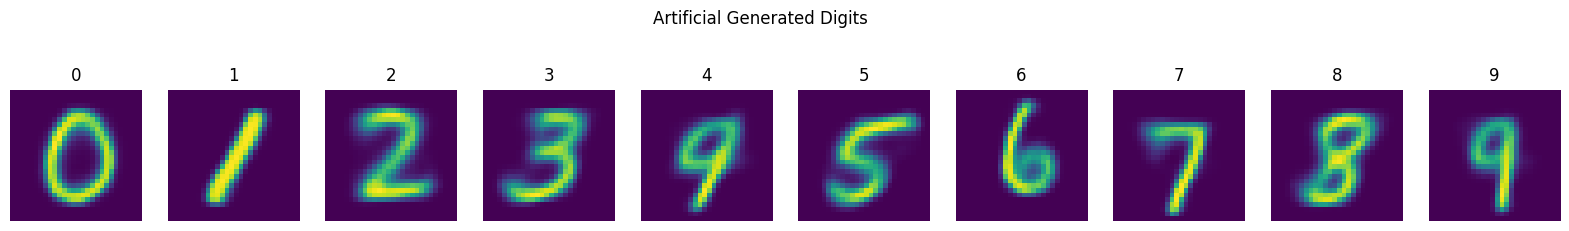

In [13]:
# select random 10 image of labeled 0 to 9 from test dataset
test_x, test_y =  get_images_1_to_10(x_test,y_test)

gen_x = cvae.predict(test_x)

plot_image(test_x,test_y, title="Origial unique Test Digits")
plot_image(gen_x,test_y,title="Artificial Generated Digits")

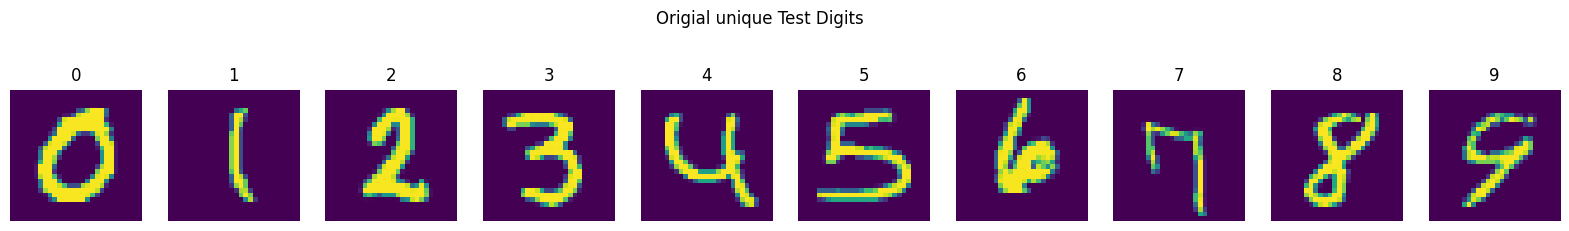

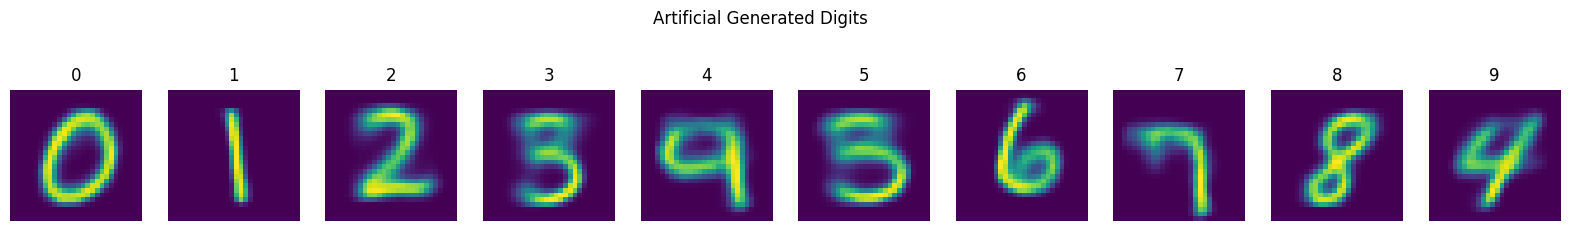

In [12]:
# select random 10 image of labeled 0 to 9 from test dataset
test_x, test_y =  get_images_1_to_10(x_train,y_train)

gen_x = cvae.predict(test_x)

plot_image(test_x,test_y, title="Origial unique Test Digits")
plot_image(gen_x,test_y,title="Artificial Generated Digits")